In [0]:
!git clone https://github.com/CSSEGISandData/COVID-19.git

import numpy as np

DATA_LENGTH = 68 # from Jan 22nd to Mar 29th

class country:
  def __init__(self, lc, ld, lr):
    # print(lc, ld, lr)
    fields = lc.split(',')
    test1 = ld.split(',')
    test2 = lr.split(',')
    # assert(fields[0]==test1[0] and fields[1]==test1[1])
    # assert(fields[0]==test2[0] and fields[1]==test2[1])
    self.raw = (lc, ld, lr)
    if fields[0] == '':
      self.name = fields[1]
    else:
      self.name = fields[0]
    self.lat = fields[2]
    self.lon = fields[3]
    self.confirmed = []
    self.deaths = []
    self.recovered = []
    for x in fields[-DATA_LENGTH:]:
      self.confirmed = np.append(self.confirmed, [int(x)])
    fields = ld.split(',')
    for x in fields[-DATA_LENGTH:]:
      self.deaths = np.append(self.deaths, [int(x)])
    fields = lr.split(',')
    for x in fields[-DATA_LENGTH:]:
      self.recovered = np.append(self.recovered, [int(x)])
    
    self.confirmed = np.expand_dims(self.confirmed, 1)
    self.deaths = np.expand_dims(self.deaths, 1)
    self.recovered = np.expand_dims(self.recovered, 1)
  
  def plot(self):
    import matplotlib.pyplot as plt
    x = range(DATA_LENGTH)
    plt.plot(x, self.deaths, color='red', label='deaths for '+self.name)
    plt.plot(x, self.confirmed, color='yellow', label='confirmed for '+self.name)
    plt.plot(x, self.recovered, color='green', label='recovered for '+self.name)
    plt.legend()
    plt.show()

PATH = './COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

countries = []

with open(PATH + 'time_series_covid19_confirmed_global.csv', 'r') as c:
  with open(PATH + 'time_series_covid19_deaths_global.csv', 'r') as d:
    with open(PATH + 'time_series_covid19_recovered_global.csv', 'r') as r:
      l = c.readline()
      l = d.readline()
      l = r.readline()
      for lc, ld, lr in zip(c, d, r):
        countries.append(country(lc, ld, lr))

print('{} countries loaded.'.format(len(countries)))

Cloning into 'COVID-19'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 16970 (delta 0), reused 2 (delta 0), pack-reused 16963
Receiving objects: 100% (16970/16970), 65.82 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (8492/8492), done.
239 countries loaded.


In [0]:
import tensorflow as tf
import os
import time
INPUT_LEN = 40

sequences = []
targets = []
for c in countries:
  num_seqs = 68 - INPUT_LEN
  for i in range(num_seqs):
    seq = c.confirmed[i:i+INPUT_LEN]
    if sum(seq) > 0:
      sequences.append(seq)
      # tgt = c.confirmed[i+1:i+21] for RNN you have to provide an INPUT_LEN length sequence as output
      tgt = c.confirmed[i+INPUT_LEN]
      targets.append(tgt)
sequences = np.asarray(sequences, dtype=np.int)
targets = np.asarray(targets, dtype=np.int)
dataset = tf.data.Dataset.from_tensor_slices((sequences, targets))
DATASET_SIZE = len(sequences)
print('database creation completed. contains {} items.'.format(len(sequences)))

database creation completed. contains 5166 items.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

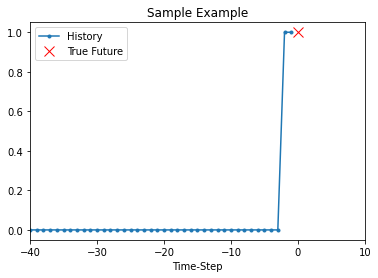

In [0]:
import matplotlib.pyplot as plt

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([sequences[155], targets[155]], 0, 'Sample Example')

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE)
train_size = int(DATASET_SIZE * 0.7)
valid_size = DATASET_SIZE - train_size

train_dataset = dataset.take(train_size)
valid_dataset = dataset.skip(train_size)
valid_dataset = dataset.take(valid_size)

train_dataset = train_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [0]:
lstm_model = tf.keras.models.Sequential([
                                         tf.keras.layers.LSTM(32, input_shape=sequences.shape[-2:]),
                                         tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mae')

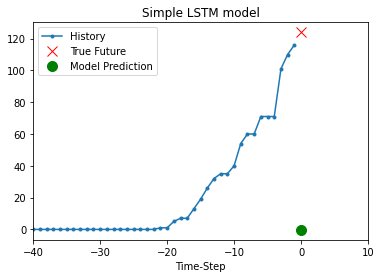

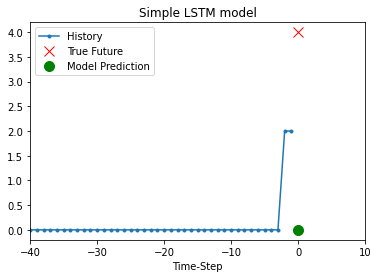

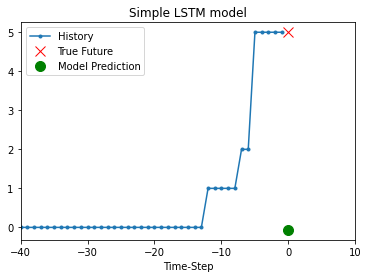

In [0]:
for x, y in valid_dataset.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(), lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
EPOCHS = 100

lstm_model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset)

Epoch 1/100
113/113 [==============================] - 1s 8ms/step - loss: 1476.7632 - val_loss: 1282.1941
Epoch 2/100
113/113 [==============================] - 0s 4ms/step - loss: 1396.2644 - val_loss: 1240.1146
Epoch 3/100
113/113 [==============================] - 1s 4ms/step - loss: 1319.1742 - val_loss: 1381.8514
Epoch 4/100
113/113 [==============================] - 0s 4ms/step - loss: 1386.9110 - val_loss: 1385.6926
Epoch 5/100
113/113 [==============================] - 0s 4ms/step - loss: 1412.5990 - val_loss: 1318.8661
Epoch 6/100
113/113 [==============================] - 0s 4ms/step - loss: 1393.2656 - val_loss: 1587.3037
Epoch 7/100
113/113 [==============================] - 0s 4ms/step - loss: 1329.0400 - val_loss: 1108.2607
Epoch 8/100
113/113 [==============================] - 0s 4ms/step - loss: 1370.9711 - val_loss: 1539.5677
Epoch 9/100
113/113 [==============================] - 0s 4ms/step - loss: 1386.1018 - val_loss: 1496.1985
Epoch 10/100
113/113 [===============

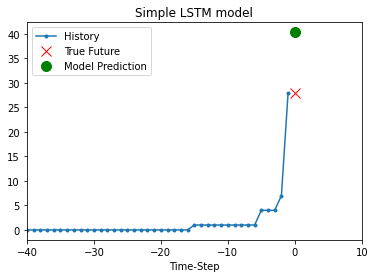

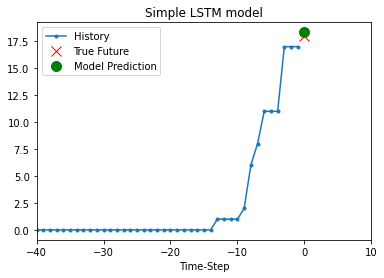

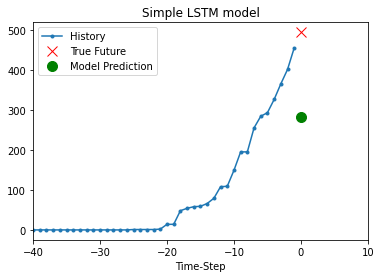

In [0]:
for x, y in valid_dataset.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(), lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
error = 0
for x, y in valid_dataset:
  y_p = lstm_model.predict(x)
  for i in range(len(y)):
    error += abs(y[i].numpy() - y_p[i])
print('error is {}'.format(error/valid_size))

error is [1417.31631595]


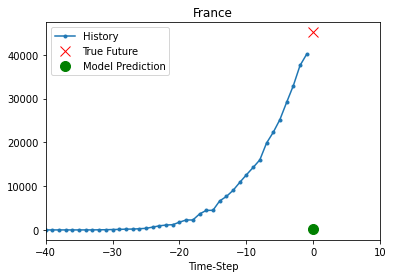

In [0]:
i = countries[116].confirmed[-INPUT_LEN:]
i = np.expand_dims(i, 0)
o = lstm_model.predict(i)
plot = show_plot([i[0], 45169, o[0]], 0, 'France')